 **Обучим градиентный бустинг c помощью библиотеки catboost для нашей задачи регрессии.**
 
**Градиентный бустинги обычно показывают неплохие результаты в задачах на табличных данных.**

**Для нашего кейса - выбор этого алгоритма помимо прочего обусловлен тем, что у нас есть ряд категориальных признаков, которые catboost обрабатывает самостоятельно без дополнительных преобразований с нашей стороны (label encoding или ohe-hot encoding и т.п.)**

# Загрузка данных и необходимых библиотек

In [ ]:
!pip install catboost
!pip install optuna

     |████████████████████████████████| 76.3 MB 101 kB/s 
     |████████████████████████████████| 308 kB 5.2 MB/s 
     |████████████████████████████████| 80 kB 8.4 MB/s 
     |████████████████████████████████| 209 kB 71.7 MB/s 
     |████████████████████████████████| 75 kB 3.6 MB/s 
     |████████████████████████████████| 49 kB 4.9 MB/s 
     |████████████████████████████████| 149 kB 74.3 MB/s 
     |████████████████████████████████| 112 kB 66.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=d00ca667e7823c434d5a6b42a998feb4266302b39b54b29a42f645d0b3fc393f
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import pandas as pd
import numpy as np

import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from catboost import CatBoostRegressor, Pool

import optuna

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
RANDOM_SEED = 314
EARLY_STOPPING_ROUND = 100

In [ ]:
df = pd.read_excel("DATA.xlsx").drop(['Unnamed: 0'], axis=1)
df.dtypes

name                     object
price                     int64
grade                   float64
year             datetime64[ns]
run                       int64
back                     object
color                    object
tax                       int64
transmission             object
drive                    object
rudder                   object
owners                    int64
pasport                  object
cr_date          datetime64[ns]
views                     int64
comment                  object
engine_volume           float64
horsepower                int64
engine_type              object
car_brand                object
car_model                object
log_price               float64
car_age                   int64
popularity              float64
dtype: object

# Первичный анализ данных и препроцессинг

In [ ]:
df.head()

,name,price,grade,year,run,back,color,tax,transmission,drive,rudder,owners,pasport,cr_date,views,comment,engine_volume,horsepower,engine_type,car_brand,car_model,log_price,car_age,popularity
0,Jeep Grand Cherokee IV (WK2) Рестайлинг,4070000,6.0,2018-01-01,56500,внедорожник 5 дв.,серебристый,18225,AT,полный,левый,1,Оригинал,2021-11-20,2482,Автомобиль покупался в США комплектация S Limi...,3.0,243,дизель,Jeep,Grand Cherokee IV (WK2) Рестайлинг,15.219154,1435,146.058824
1,LADA (ВАЗ) 2107,129000,4.0,2005-01-01,77000,седан,зеленый,888,MT,задний,левый,2,Оригинал,2021-11-23,553,Читаем внимательно.,1.6,74,бензин,LADA,(ВАЗ) 2107,11.767575,6183,39.571429
2,Mercedes-Benz GLK-Класс 300 I (X204),1050000,6.0,2010-01-01,145000,внедорожник 5 дв.,бежевый,17325,AT,полный,левый,2,Оригинал,2021-11-26,242,Автомобиль находится в отличном состоянии. Все...,3.0,231,бензин,Mercedes-Benz,GLK-Класс 300 I (X204),13.864302,4357,22.090909
3,Mercedes-Benz A-Класс 140 I (W168),199000,4.0,2000-01-01,220000,хэтчбек 5 дв.,синий,984,MT,передний,левый,3,Дубликат,2021-11-27,17,Добрый день! Выставляется на продажу Mercedes ...,1.4,82,бензин,Mercedes-Benz,A-Класс 140 I (W168),12.201065,8010,1.800000
4,BMW X1 20i I (E84) Рестайлинг,1098000,7.0,2012-01-01,167193,внедорожник 5 дв.,оранжевый,9200,AT,полный,левый,3,Оригинал,2021-11-27,8,10 000 подарков за покупку автомобиля с пробег...,2.0,184,бензин,BMW,X1 20i I (E84) Рестайлинг,13.909002,3627,0.900000


In [ ]:
df['grade'] = df['grade'].astype(str)

## Рассмотрим числовые признаки

In [ ]:
df.describe()

,price,run,tax,owners,views,engine_volume,horsepower,log_price,car_age,popularity
count,3.275300e+04,32753.000000,32753.000000,32753.000000,32753.000000,32655.000000,32753.000000,32753.000000,32753.000000,32753.000000
mean,1.725248e+06,129948.167893,14429.299392,2.191097,195.471193,2.280805,180.035600,13.816284,3606.406161,13.849865
std,2.617066e+06,85456.823645,25309.488396,1.374991,673.408661,0.968362,98.476681,1.045289,2345.054066,31.894197
min,1.200000e+04,1.000000,132.000000,1.000000,0.000000,0.600000,11.000000,9.392745,339.000000,0.011765
25%,5.590000e+05,70000.000000,3000.000000,1.000000,30.000000,1.600000,120.000000,13.233907,1800.000000,3.000000
50%,9.990000e+05,125000.000000,5250.000000,2.000000,76.000000,2.000000,150.000000,13.814511,3261.000000,6.785714
75%,1.799000e+06,172000.000000,13260.000000,3.000000,182.000000,2.500000,204.000000,14.402742,5088.000000,14.700000
max,9.000000e+07,999999.000000,285750.000000,56.000000,51528.000000,8.300000,800.000000,18.315320,27003.000000,3359.500000


In [ ]:
(df.isnull().sum()/df.shape[0]) \
.sort_values(ascending=False)

comment          0.007847
engine_volume    0.002992
popularity       0.000000
rudder           0.000000
price            0.000000
grade            0.000000
year             0.000000
run              0.000000
back             0.000000
color            0.000000
tax              0.000000
transmission     0.000000
drive            0.000000
owners           0.000000
car_age          0.000000
pasport          0.000000
cr_date          0.000000
views            0.000000
horsepower       0.000000
engine_type      0.000000
car_brand        0.000000
car_model        0.000000
log_price        0.000000
name             0.000000
dtype: float64

Text(0.5, 1.0, 'Price')

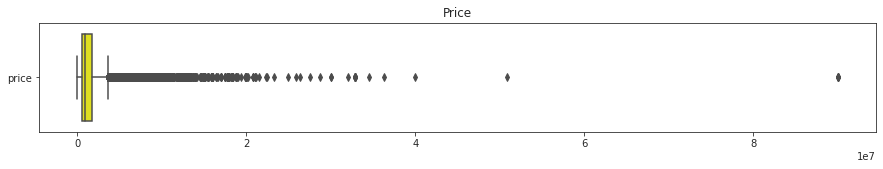

In [ ]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(15, 2)
sns.boxplot(data=df[['price']], orient="h", ax=ax, color='yellow').set_title('Price')

Text(0.5, 1.0, 'Run')

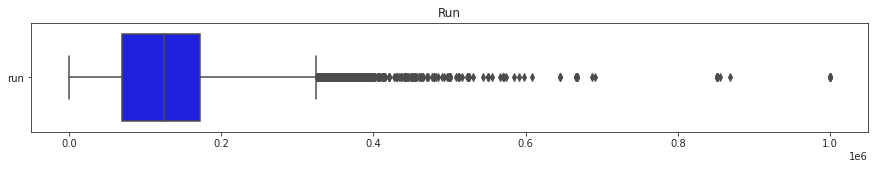

In [ ]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(15, 2)
sns.boxplot(data=df[['run']], orient="h", ax=ax, color='blue').set_title('Run')

Text(0.5, 1.0, 'Tax')

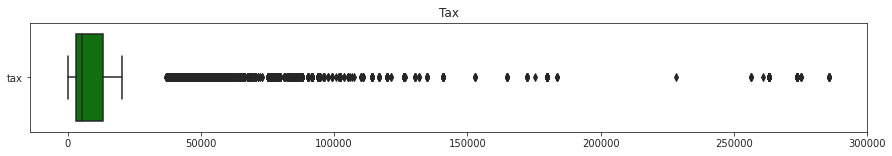

In [ ]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(15, 2)
sns.boxplot(data=df[['tax']], orient="h", ax=ax, color='green').set_title('Tax')

Text(0.5, 1.0, 'Car_age')

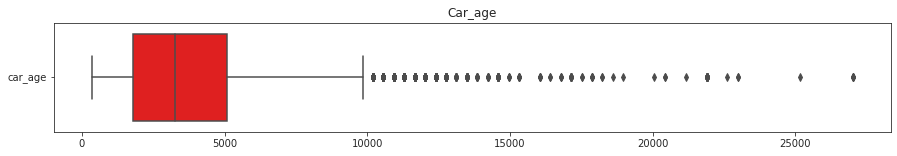

In [ ]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(15, 2)
sns.boxplot(data=df[['car_age']], orient="h", ax=ax, color='red').set_title('Car_age')

Text(0.5, 1.0, 'Views')

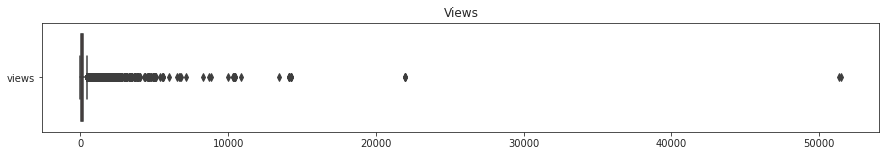

In [ ]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(15, 2)
sns.boxplot(data=df[['views']], orient="h", ax=ax, color='brown').set_title('Views')

Text(0.5, 1.0, 'Horsepower')

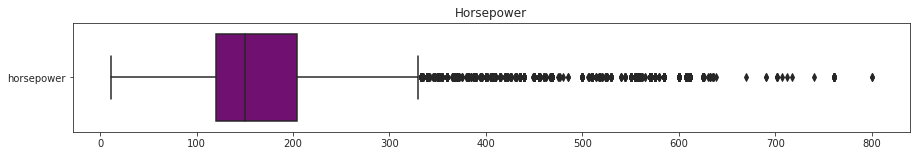

In [ ]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(15, 2)
sns.boxplot(data=df[['horsepower']], orient="h", ax=ax, color='purple').set_title('Horsepower')

Text(0.5, 1.0, 'Popularity')

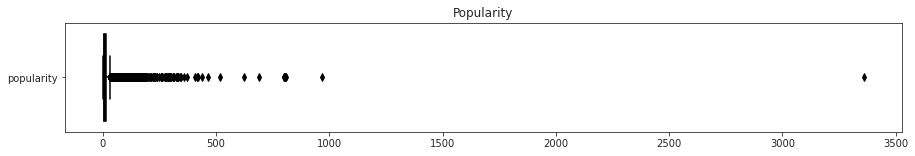

In [ ]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(15, 2)
sns.boxplot(data=df[['popularity']], orient="h", ax=ax, color='black').set_title('Popularity')

Text(0.5, 1.0, 'Owners')

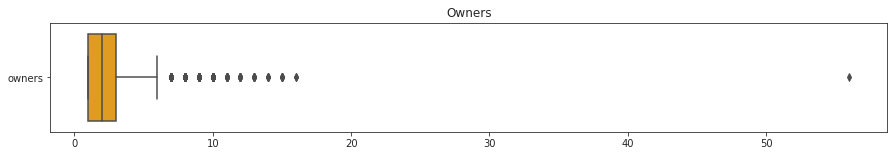

In [ ]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(15, 2)
sns.boxplot(data=df[['owners']], orient="h", ax=ax, color='orange').set_title('Owners')

Text(0.5, 1.0, 'Engine_volume')

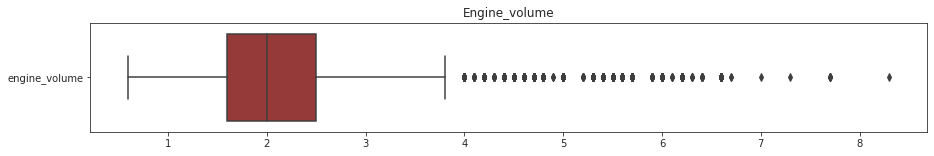

In [ ]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(15, 2)
sns.boxplot(data=df[['engine_volume']], orient="h", ax=ax, color='brown').set_title('Engine_volume')

**Вывод:**

**В данных есть выбросы, но некоторые логичны, а некоторые выглядят странно, а именно максимальное значение views, populatiry и owners. Отфильтруем их.**

In [ ]:
df = df[df['views'] <= 14000]
df = df[df['popularity'] <= 1000]
df = df[df['owners'] <= 20]

Text(0.5, 1.0, 'Views')

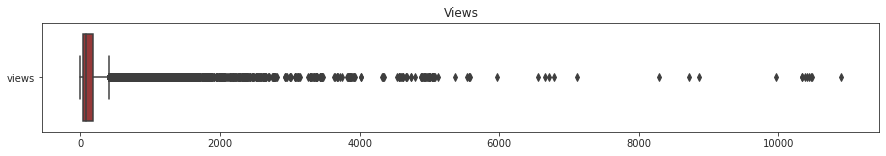

In [ ]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(15, 2)
sns.boxplot(data=df[['views']], orient="h", ax=ax, color='brown').set_title('Views')

Text(0.5, 1.0, 'Popularity')

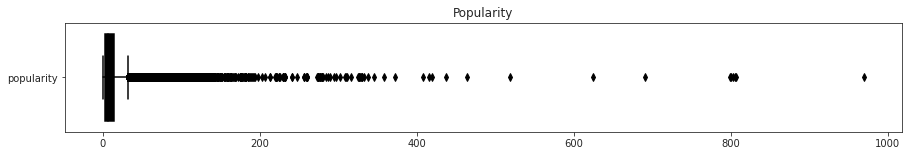

In [ ]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(15, 2)
sns.boxplot(data=df[['popularity']], orient="h", ax=ax, color='black').set_title('Popularity')

Text(0.5, 1.0, 'Owners')

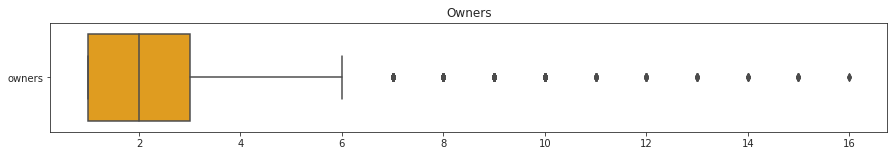

In [ ]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(15, 2)
sns.boxplot(data=df[['owners']], orient="h", ax=ax, color='orange').set_title('Owners')

**Уже лучше.**

## Посмотрим как обстоит ситуация с корреляцией фичей

In [ ]:
df_corr = df[['engine_volume',	'horsepower', 'car_age',	'popularity', 'views', 'owners', 'run', 'tax', 'log_price']].corr()['log_price'] \
.abs() \
.sort_values(ascending=False) \
.to_frame() \
.reset_index() \
.rename(columns={'index': 'feat_name', 'log_price': "value"})
df_corr

,feat_name,value
0,log_price,1.000000
1,car_age,0.687535
2,horsepower,0.636794
3,run,0.543073
4,tax,0.500784
5,engine_volume,0.457337
6,owners,0.304775
7,views,0.021504
8,popularity,0.011003


**Удалим слабоскоррелированные признаки (меньше 2,5%)**

In [ ]:
feats_with_low_corr_value = df_corr[df_corr['value'] <= 0.025].feat_name.values

In [ ]:
feats_with_low_corr_value

array(['views', 'popularity'], dtype=object)

In [ ]:
df = df.drop(list(feats_with_low_corr_value), axis=1)

**Неплохо.**

## Поработаем с категориальными признаками

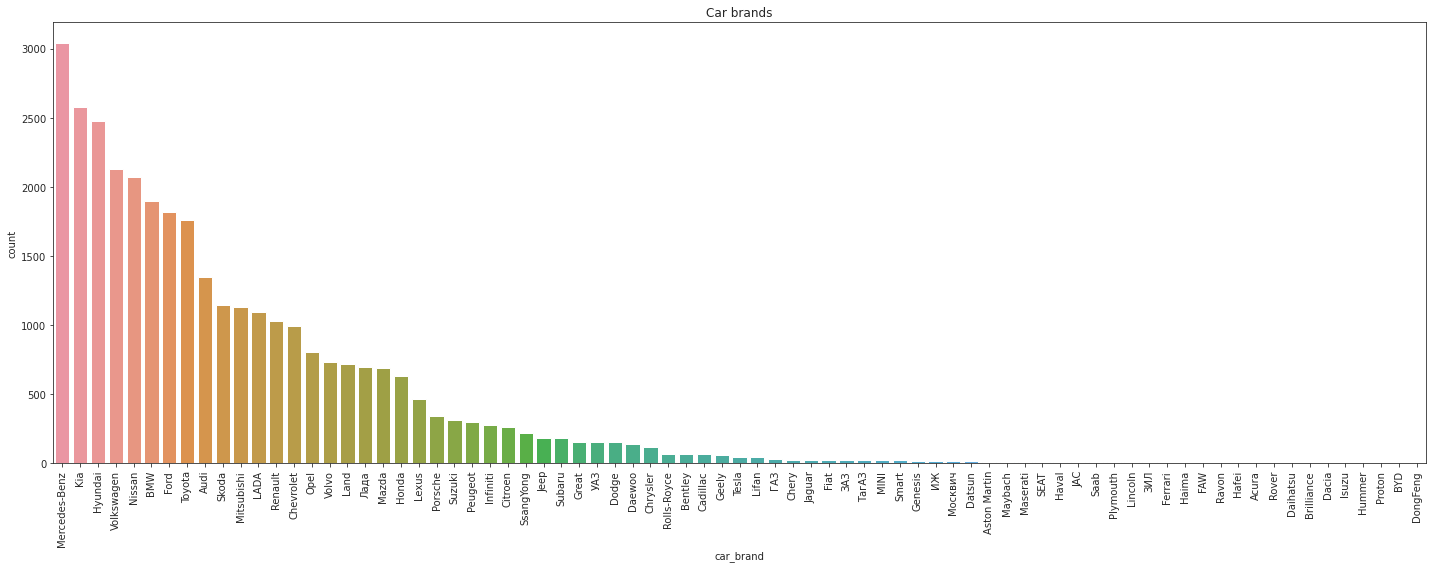

In [ ]:
plt.figure(figsize=(20, 8));
sns.barplot(data=df.car_brand.value_counts().to_frame().reset_index().rename(columns={"index": "car_brand", "car_brand": "count"}), 
            x='car_brand', 
            y='count') \
            .set_title('Car brands')
plt.xticks(rotation=90)
plt.tight_layout()

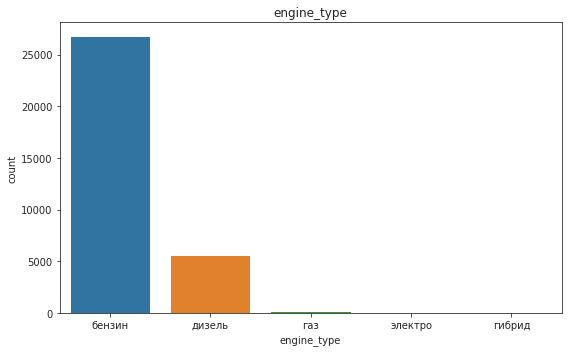

In [ ]:
plt.figure(figsize=(8, 5));
sns.barplot(data=df.engine_type.value_counts().to_frame().reset_index().rename(columns={"index": "engine_type", "engine_type": "count"}), 
            x='engine_type', 
            y='count') \
            .set_title('engine_type')
plt.tight_layout()

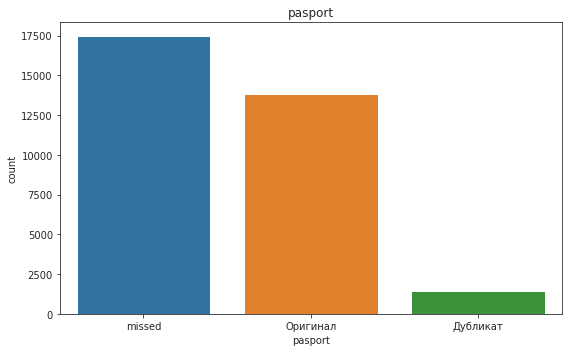

In [ ]:
plt.figure(figsize=(8, 5));
sns.barplot(data=df.pasport.value_counts().to_frame().reset_index().rename(columns={"index": "pasport", "pasport": "count"}), 
            x='pasport', 
            y='count') \
            .set_title('pasport')
plt.tight_layout()

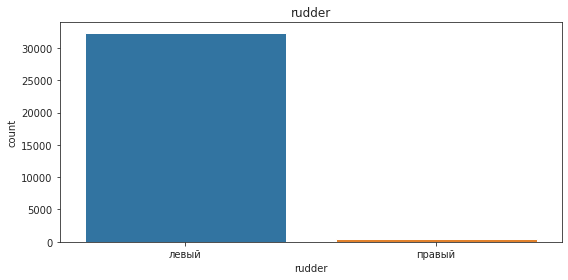

In [ ]:
plt.figure(figsize=(8, 4));
sns.barplot(data=df.rudder.value_counts().to_frame().reset_index().rename(columns={"index": "rudder", "rudder": "count"}), 
            x='rudder', 
            y='count') \
            .set_title('rudder')
plt.tight_layout()

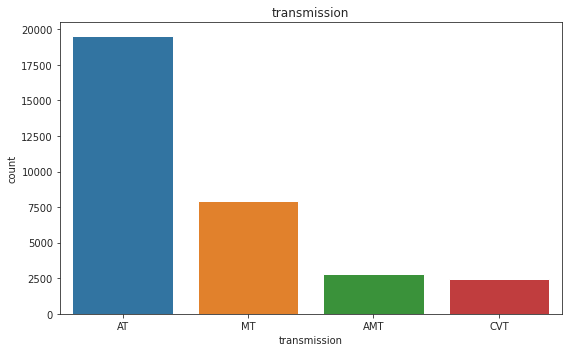

In [ ]:
plt.figure(figsize=(8, 5));
sns.barplot(data=df.transmission.value_counts().to_frame().reset_index().rename(columns={"index": "transmission", "transmission": "count"}), 
            x='transmission', 
            y='count') \
            .set_title('transmission')
plt.tight_layout()

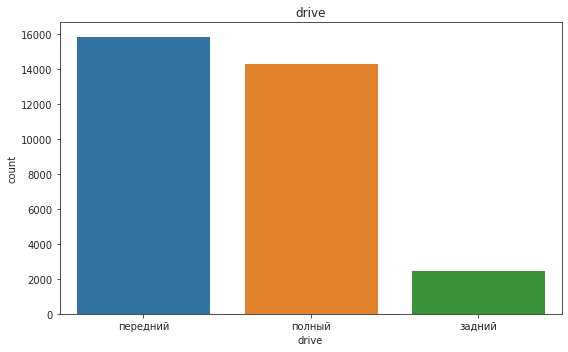

In [ ]:
plt.figure(figsize=(8, 5));
sns.barplot(data=df.drive.value_counts().to_frame().reset_index().rename(columns={"index": "drive", "drive": "count"}), 
            x='drive', 
            y='count') \
            .set_title('drive')
plt.tight_layout()

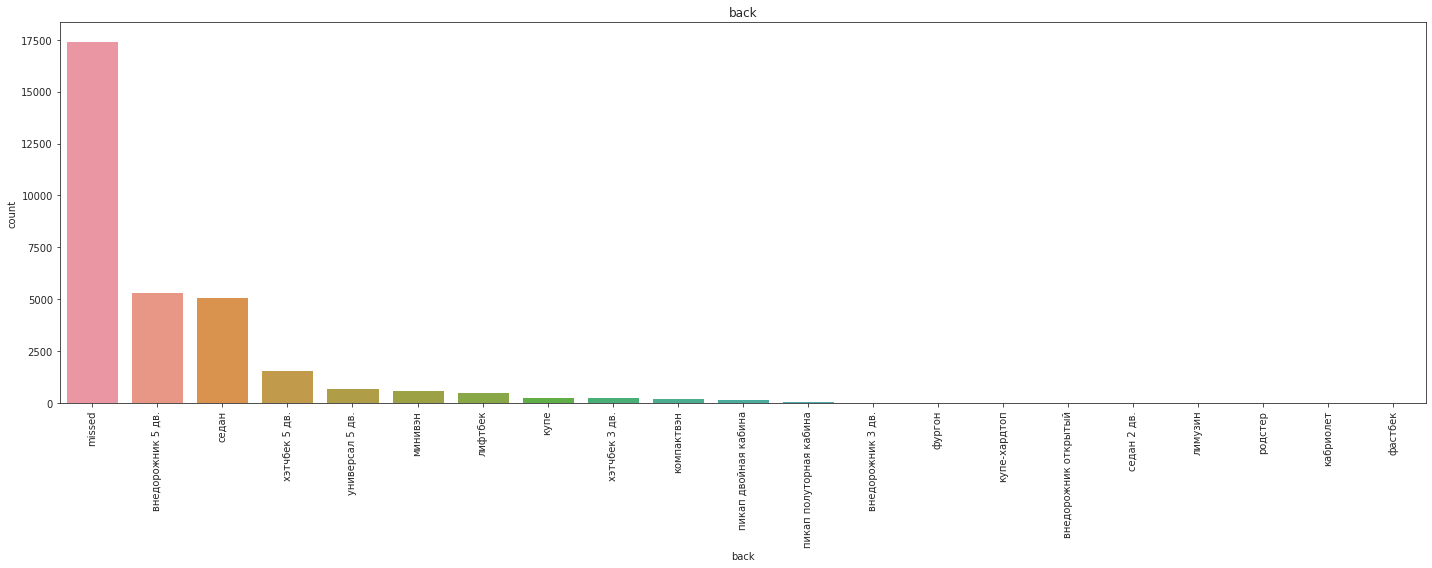

In [ ]:
plt.figure(figsize=(20, 8));
sns.barplot(data=df.back.value_counts().to_frame().reset_index().rename(columns={"index": "back", "back": "count"}), 
            x='back', 
            y='count') \
            .set_title('back')
plt.xticks(rotation=90)
plt.tight_layout()

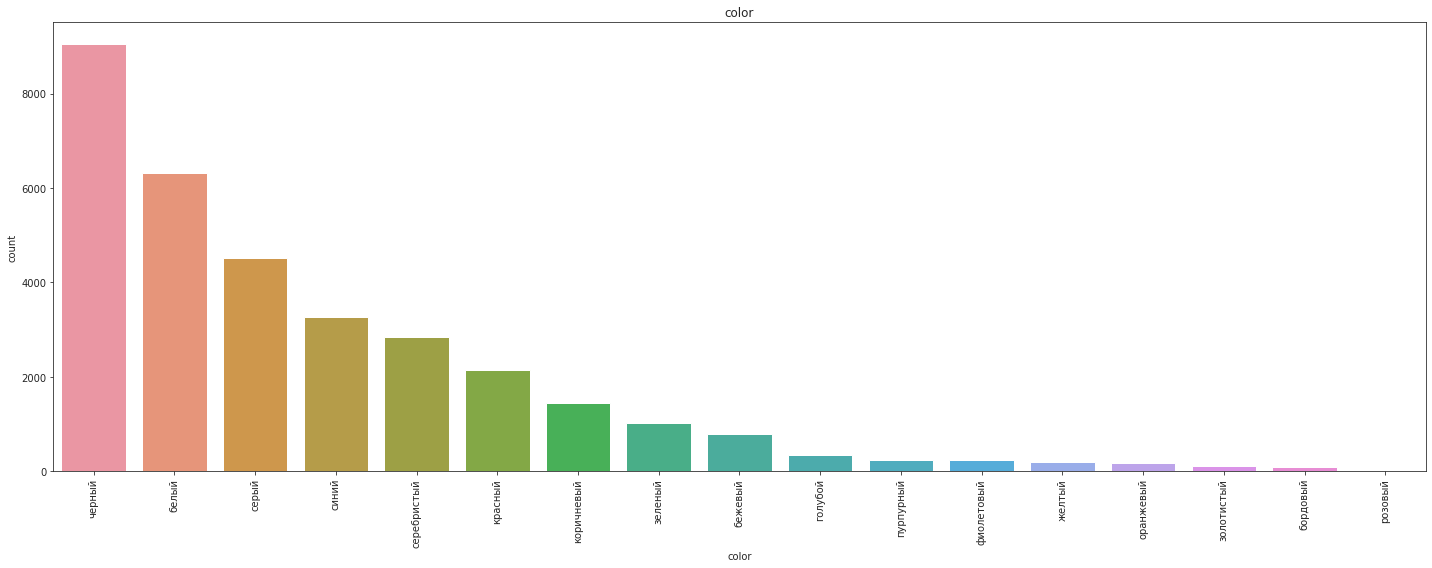

In [ ]:
plt.figure(figsize=(20, 8));
sns.barplot(data=df.color.value_counts().to_frame().reset_index().rename(columns={"index": "color", "color": "count"}), 
            x='color', 
            y='count') \
            .set_title('color')
plt.xticks(rotation=90)
plt.tight_layout()

Text(0.5, 1.0, 'grade')

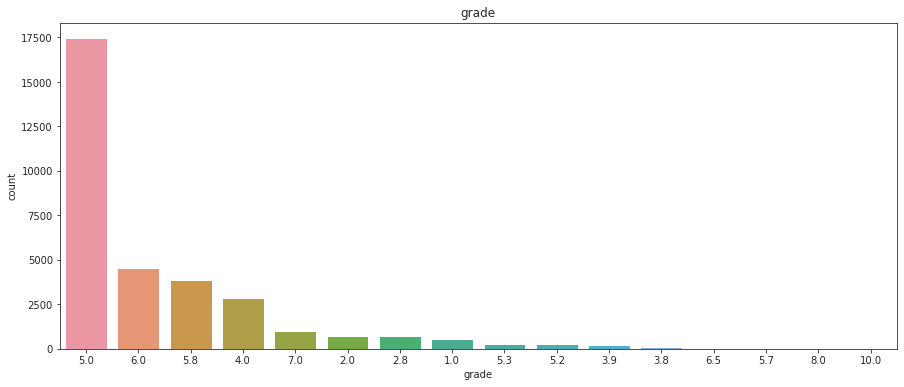

In [ ]:
plt.figure(figsize=(15, 6));
sns.barplot(data=df.grade.value_counts().to_frame().reset_index().rename(columns={"index": "grade", "grade": "count"}), 
            x='grade', 
            y='count') \
            .set_title('grade')

In [ ]:
df = df.drop(['pasport', 'back'], axis=1)

**Вывод:**

**В фиче pasport и back очень много значений missed, - это означает, что при парсинге не удалось собрать эти данные. Так как информации нет, то эти фичи исключим из перечня для последующего обучения модели.**

Предположения:

Разумно допустить, что в большинстве случаев есть зависимость между возрастом, пробегом, маркой автомобиля и его ценой. Мощность авто тоже должна влиять на цену, так как обычно большой мощностью обладают спортивные авто, которые, как правило, имеют высокую цену.

# Обучение модели

In [ ]:
label_col = ['log_price']
feats = ['engine_volume',	'horsepower', 'car_age',	'owners', 
         'run', 'car_model', 'car_brand', 'engine_type', 'rudder', 
         'transmission', 'drive', 'color',	'grade']
categ_feats = ['car_model', 'car_brand', 'engine_type', 'rudder', 
               'transmission', 'drive', 'color', 'grade']

Разобьем выборку на train, val и test и оценим распределение target_variable на каждой подвыборке

In [ ]:
train, test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
train_hp, val_hp = train_test_split(train, test_size=0.25, random_state=RANDOM_SEED)

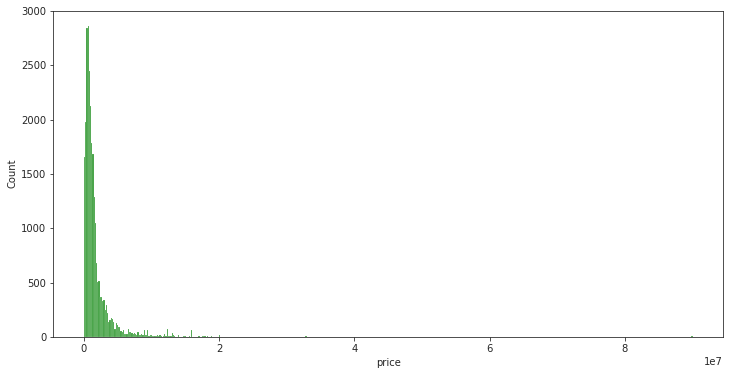

In [ ]:
plt.figure(figsize=(12, 6));
sns.histplot(train.price, color='g', bins=500)

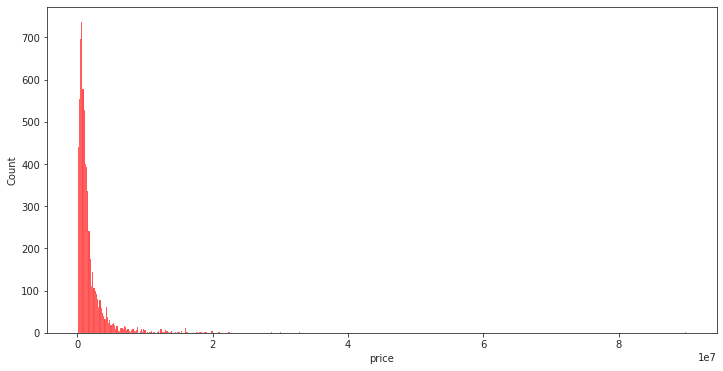

In [ ]:
plt.figure(figsize=(12, 6));
sns.histplot(test.price, color='r', bins=500)

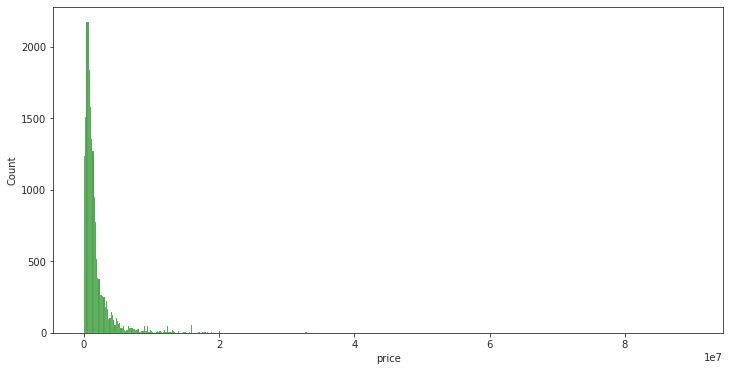

In [ ]:
plt.figure(figsize=(12, 6));
sns.histplot(train_hp.price, color='g', bins=500)

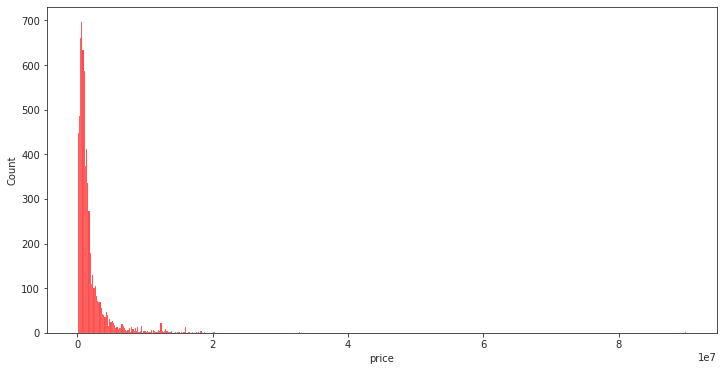

In [ ]:
plt.figure(figsize=(12, 6));
sns.histplot(val_hp.price, color='r', bins=500)

**В целом распределения очень похожи**

In [ ]:
train_pool = Pool(train[feats], label=train[label_col], cat_features=categ_feats)
test_pool = Pool(test[feats], label=test[label_col], cat_features=categ_feats)

train_hp_pool = Pool(train_hp[feats], label=train_hp[label_col], cat_features=categ_feats)
val_hp_pool = Pool(val_hp[feats], label=val_hp[label_col], cat_features=categ_feats)

## Подбор гиперпараметров

In [ ]:
def objective(trial):
    param = {}
    param['learning_rate'] = trial.suggest_discrete_uniform("learning_rate", 0.001, 0.02, 0.001)
    param['depth'] = trial.suggest_int('depth', 4, 10)
    param['l2_leaf_reg'] = trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 6.5, 0.5)
    param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
    param['border_count'] = trial.suggest_categorical('border_count', [32,5,10,20,50,100,200])
    param['grow_policy'] = 'Depthwise'
    param['iterations'] = 5000
    param['use_best_model'] = True
    param['eval_metric'] = 'RMSE'
    param['od_type'] = 'iter'
    param['od_wait'] = 20
    param['random_state'] = RANDOM_SEED
    param['logging_level'] = 'Silent'

    regressor = CatBoostRegressor(**param, task_type='GPU', devices='0:1')

    regressor.fit(train_hp_pool, 
                  eval_set=val_hp_pool,
                  early_stopping_rounds=EARLY_STOPPING_ROUND)
    loss = mean_squared_error(val_hp[label_col], regressor.predict(val_hp_pool))
    return loss

In [ ]:
"""
Внимание! Время выполнения около 2 часов.
"""
study = optuna.create_study(study_name=f'catboost-seed{RANDOM_SEED}')
study.optimize(objective, n_trials=100, timeout=28800)

[I 2021-12-25 23:32:15,174] A new study created in memory with name: catboost-seed314
[I 2021-12-25 23:33:11,061] Trial 0 finished with value: 0.042839053026135616 and parameters: {'learning_rate': 0.018000000000000002, 'depth': 8, 'l2_leaf_reg': 4.0, 'min_child_samples': 4, 'border_count': 5}. Best is trial 0 with value: 0.042839053026135616.
[I 2021-12-25 23:33:39,970] Trial 1 finished with value: 0.06255076119407921 and parameters: {'learning_rate': 0.017, 'depth': 4, 'l2_leaf_reg': 4.0, 'min_child_samples': 1, 'border_count': 5}. Best is trial 0 with value: 0.042839053026135616.
[I 2021-12-25 23:34:29,980] Trial 2 finished with value: 0.0420001614583443 and parameters: {'learning_rate': 0.002, 'depth': 7, 'l2_leaf_reg': 3.5, 'min_child_samples': 1, 'border_count': 32}. Best is trial 2 with value: 0.0420001614583443.
[I 2021-12-25 23:35:06,670] Trial 3 finished with value: 0.035135011157416476 and parameters: {'learning_rate': 0.017, 'depth': 6, 'l2_leaf_reg': 3.0, 'min_child_sample

Метрики подбора гиперпараметров

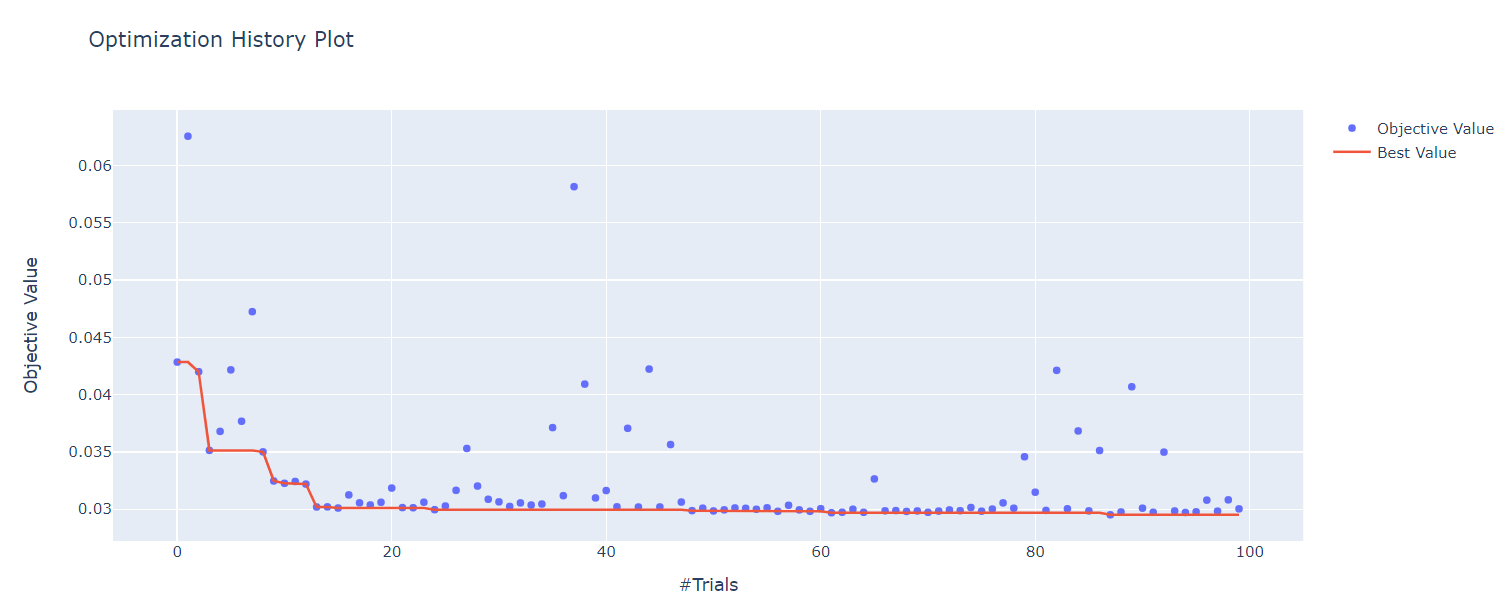



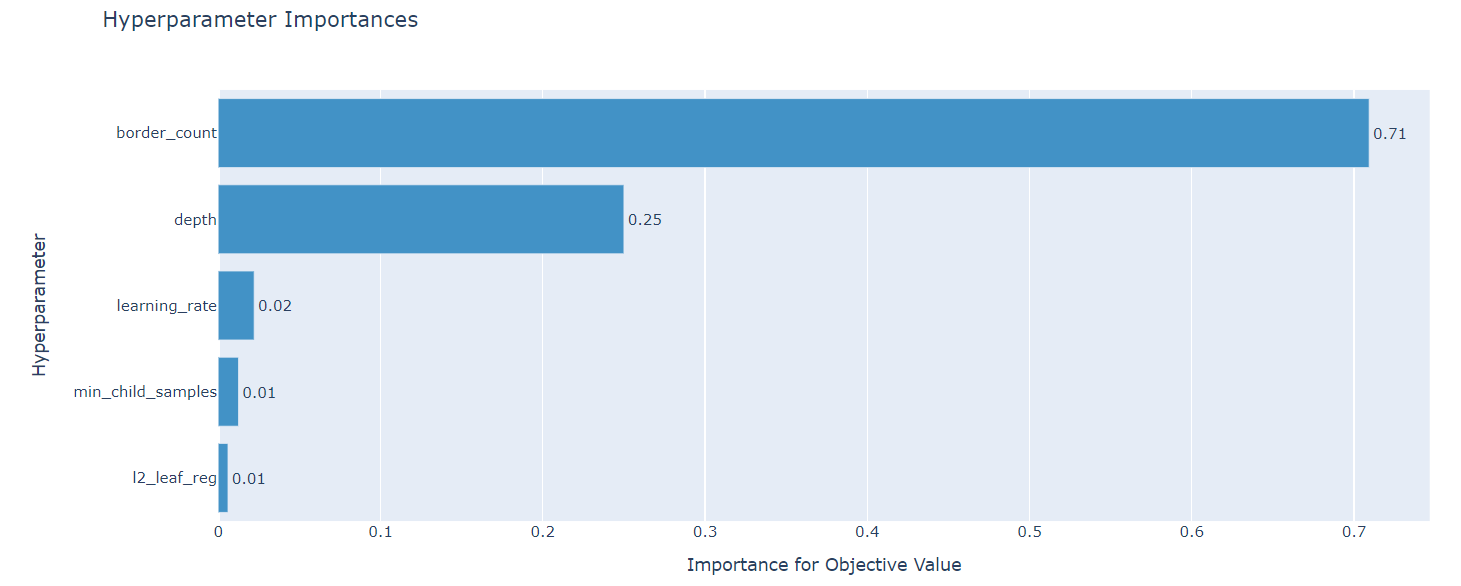

Как видим основные гиперпараметры:


1.   Border_count - число разбиений для числовых фичей
2.   Depth - глубина дерева



In [ ]:
#optuna.visualization.plot_optimization_history(study)
#optuna.visualization.plot_param_importances(study)

In [ ]:
study.best_params

{'border_count': 200,
 'depth': 10,
 'l2_leaf_reg': 2.0,
 'learning_rate': 0.015,
 'min_child_samples': 1}

## Обучение модели

In [ ]:
model = CatBoostRegressor(iterations = 50000,
                          learning_rate = 0.015,
                          depth = 10,
                          l2_leaf_reg = 2.0,
                          min_child_samples = 1,
                          border_count = 200,
                          grow_policy='Depthwise',
                          use_best_model=True,
                          loss_function='RMSE',
                          eval_metric='RMSE',
                          od_type='Iter',
                          od_wait=100,
                          random_state=RANDOM_SEED,
                          metric_period=100
                         )

model.fit(train_hp_pool, 
          eval_set=val_hp_pool)

0:	learn: 1.0335725	test: 1.0394837	best: 1.0394837 (0)	total: 147ms	remaining: 2h 2m 47s
100:	learn: 0.3575114	test: 0.3604062	best: 0.3604062 (100)	total: 5.62s	remaining: 46m 16s
200:	learn: 0.2202285	test: 0.2352941	best: 0.2352941 (200)	total: 11.3s	remaining: 46m 45s
300:	learn: 0.1855523	test: 0.2099639	best: 0.2099639 (300)	total: 16.4s	remaining: 45m 6s
400:	learn: 0.1714205	test: 0.2008447	best: 0.2008447 (400)	total: 20.7s	remaining: 42m 41s
500:	learn: 0.1622324	test: 0.1953865	best: 0.1953865 (500)	total: 24.8s	remaining: 40m 52s
600:	learn: 0.1547646	test: 0.1916200	best: 0.1916200 (600)	total: 28.9s	remaining: 39m 35s
700:	learn: 0.1480784	test: 0.1884548	best: 0.1884548 (700)	total: 32.9s	remaining: 38m 35s
800:	learn: 0.1423960	test: 0.1860102	best: 0.1860102 (800)	total: 36.7s	remaining: 37m 36s
900:	learn: 0.1373970	test: 0.1840783	best: 0.1840783 (900)	total: 40.5s	remaining: 36m 47s
1000:	learn: 0.1322562	test: 0.1821294	best: 0.1821294 (1000)	total: 44.5s	remainin

## Важность признаков

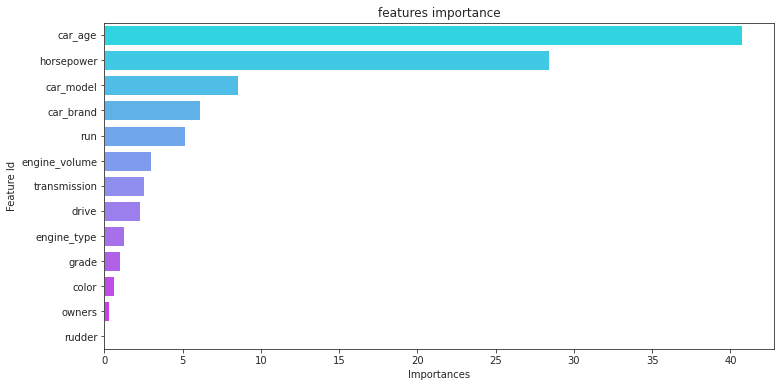

In [ ]:
df_feature_importance = pd.DataFrame(model.get_feature_importance(prettified=True))

plt.figure(figsize=(12, 6));
feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance, palette="cool");
plt.title('features importance');

В топ вышли фичи: возраст авто, количество лошадинных сил, модель, бренд, пробег и объем двигателя. Что в целом совпадает с нашими изначальными гипотезами. 

Интересно, следующее: 
*   пробег влияет не так сильно, как возраст. Возможно это по причине того, что с пробегом можно манипулировать ("скручивать"), а с возрастом такое не возможно.
*   количество владельцев почти не влияет на цену, так как в большинстве случаев количество владельцев достаточно разумная величина и какую-то доп.информацию для модели не дает.



# Предсказание для тестовой выборки

In [ ]:
y_pred = model.predict(test_pool)

In [ ]:
test['log_price_pred'] = y_pred
test['price_pred'] = np.exp(y_pred)

Метрики

In [ ]:
rmse_test = math.sqrt(mean_squared_error(test.price.values, test.price_pred.values))

r2_test = r2_score(test.price.values, test.price_pred.values)

# Adjusted R2 Score
n = train[feats].shape[0] # total no of datapoints
p = train[feats].shape[1] # total no of independent features
adj_r2_test = 1 - (1 - r2_test) * (n - 1) / (n - p - 1)

print("Evaluation on test data")
print("RMSE: {:.2f}".format(rmse_test))
print("R2: {:.2f}".format(r2_test))
print("Adjusted R2: {:.2f}".format(adj_r2_test))

Evaluation on test data
RMSE: 497502.11
R2: 0.96
Adjusted R2: 0.96


**По значению RMSE непонятно насколько хорошую модель мы обучили, поэтому мы дополнительно посчитали коэффициенты детерминации R2 и adjusted R2 и для них у нас получили очень неплохие значения**

## Графики

Попробуем оценить качество нашей модели визуально.

Построим распределение target'а и predict'а на test set.

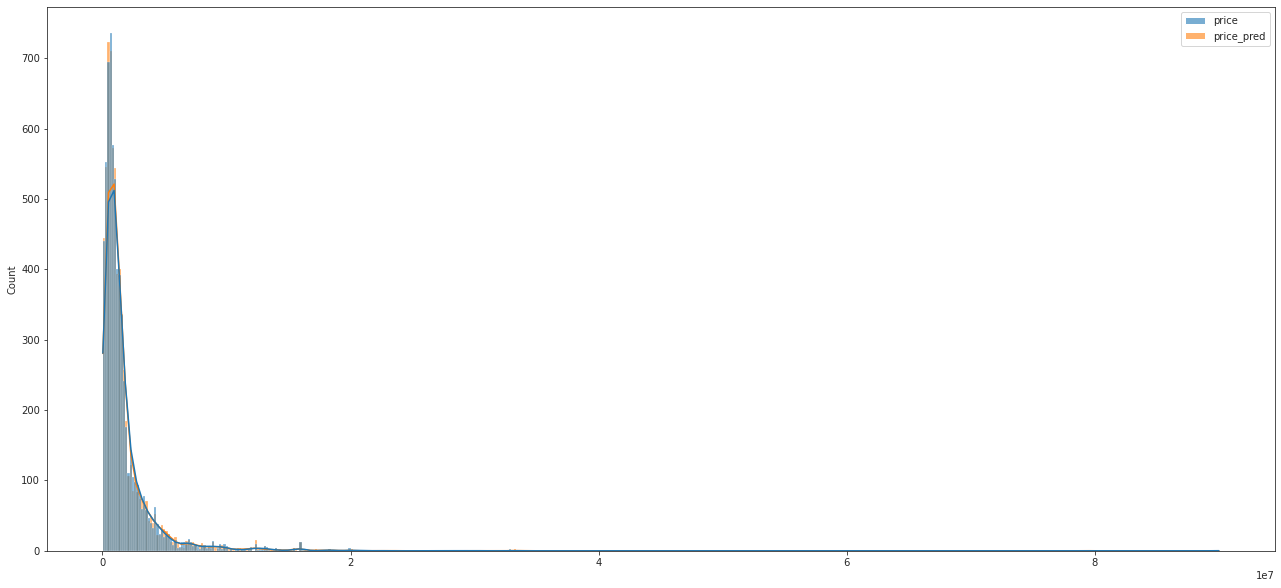

In [ ]:
plt.figure(figsize=(22, 10));
sns.histplot([test.price, test.price_pred], color=['g', 'r'], bins=500, alpha=0.6, kde=True)

Распределения очень близки.

Посчитаем модуль разности между target и predict на test и также построим распределение, если predict близок к target'у, то подавляющее большинство значений будет близко к нулю.

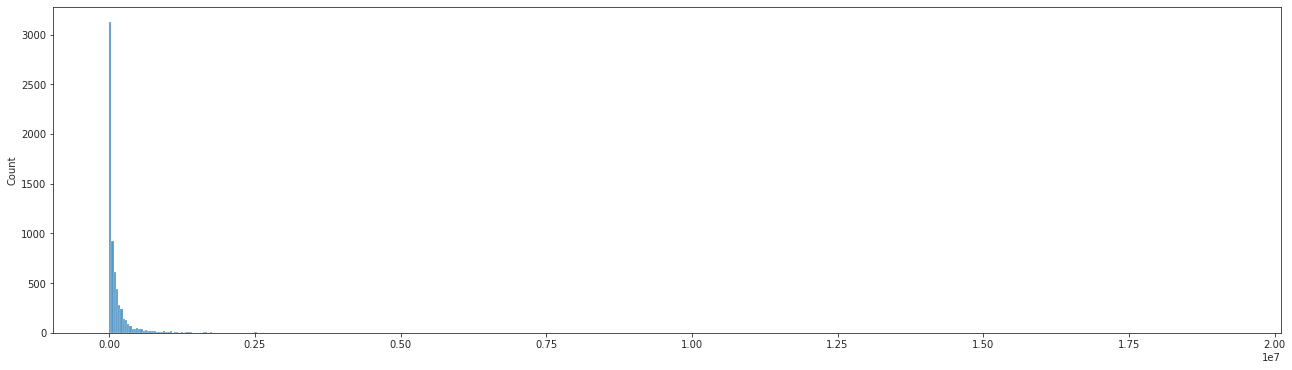

In [ ]:
plt.figure(figsize=(22, 6));
sns.histplot(abs(test.price - test.price_pred), bins=500)

В целом неплохо.

Построим еще relplot и lmplot

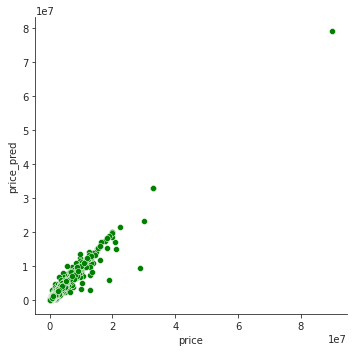

In [ ]:
sns.relplot(data=test[['price', 'price_pred']], x='price', y='price_pred', color='g', height=5, aspect=1)

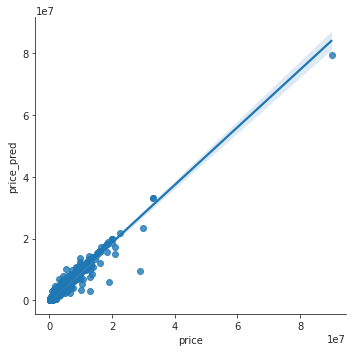

In [ ]:
sns.lmplot(data=test[['price', 'price_pred']], x='price', y='price_pred', height=5, aspect=1)

**Опять же получились достаточно неплохие результаты**

# Итоги

1. В целом получилась неплохая модель (R2 = 0.96), можно сказать, что по имеющимся данным можно решать поставленную задачу.
2. Выдвинутые гипотезы по фичам в целом подтвердились.
3. Выбор модели оправдан.
4. Имеем смысл улучшить качество сбора информации, а именно признаки pasport - это информация о документах (дубликат или оригинал) и back - это тип кузова авто. Также имеет смысл улучшить признак car_model - информация о модели, так как в нем очень много информации, которую необходимо обрабатывать как тексты (модели, поколения, генерации авто и т.п.)

